In [6]:
import tensorflow as tf
import numpy as np
print(tf.__version__)

2.9.1


In [3]:
input_shape = (2, 25, 25, 3)
x = tf.random.normal(input_shape)

In [4]:
conv_layer = tf.keras.layers.Conv2D(
    filters=5, kernel_size=(2, 2), strides=1, use_bias=True, input_shape=input_shape[1:]
)

In [5]:
o = conv_layer(x)

2022-08-11 12:00:10.287027: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


In [ ]:
vocaburary = {'The': 1, 'torrential': 2, 'rain': 3, ...}

# Convolutional Neural Network

## Manual Kernel

Manually create vertical & horizontal kernal

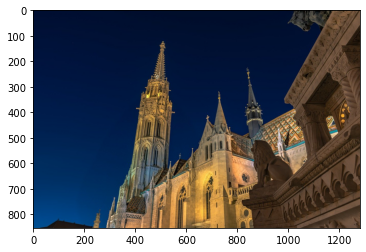

In [3]:
def plot_maps(outputs, titles):
    fig, axes = plt.subplots(1, len(outputs), figsize=(12, 8), dpi=100)
    for (ax, o, t) in zip(axes, outputs, titles):
        ax.imshow(o.squeeze(), cmap="bone")
        ax.axis("off")
        ax.set_title(t, fontsize=12)

img = Image.open("./budapest.jpg")
plt.imshow(img)
plt.show()

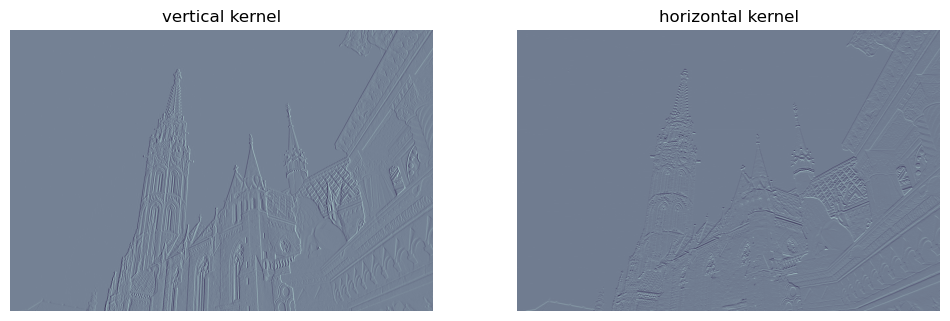

In [4]:
# (B, C_in, H_in, W_in) = (1, 3, 853, 1280)
img_tensor = torch.FloatTensor(np.array(img)).permute(2, 0, 1).unsqueeze(0)

# vertical_kernel: (C_out, C_in, K_H, K_W) = (1, 3, 3, 3)
v_kernel = torch.FloatTensor([[1, 0, -1], 
                              [1, 0, -1], 
                              [1, 0, -1]]).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0)

# horizontal_kernel: (C_out, C_in, K_H, K_W)  = (1, 3, 3, 3)
h_kernel = torch.FloatTensor([[ 1,  1,  1], 
                              [ 0,  0,  0], 
                              [-1, -1, -1]]).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0)

v_output = torch.nn.functional.conv2d(img_tensor, weight=v_kernel, bias=None)
h_output = torch.nn.functional.conv2d(img_tensor, weight=h_kernel, bias=None)

outputs = [v_output, h_output]
titles = ["vertical kernel", "horizontal kernel"]
# Plotting Maps
plot_maps(outputs, titles)

## Layers

### Convolution Layer

[`nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#conv2d) needs following arguments.

* `in_channels`: input channel number
* `out_channels`: output channel number
* `kernel_size`: kernel(filter) size, if integer type is given, it'll automatically set the same height and width. Also, can give tuple to give different size of height and width.
* `stride`: the number of stride 
* `padding`: the number of padding, like `kernel_size`, if integer type is given, it'll pad around image with height and width. 

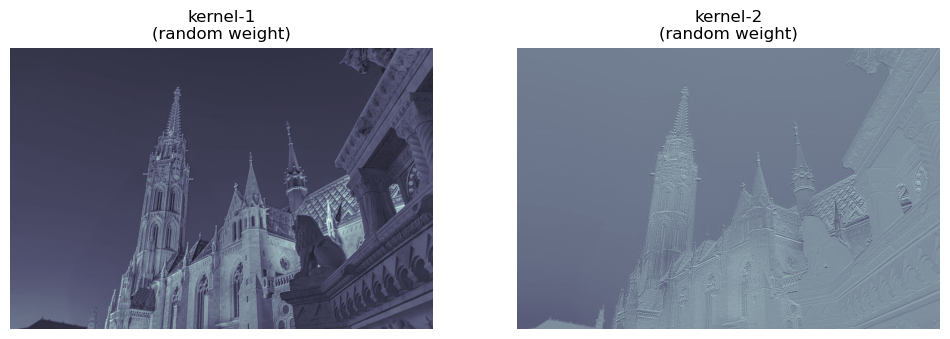

In [5]:
seed = 777
torch.manual_seed(seed)
conv_layer = nn.Conv2d(in_channels=3, 
                       out_channels=2, 
                       kernel_size=(3, 3), 
                       stride=1,
                       padding=0)
outputs = conv_layer(img_tensor).detach()
titles = ["kernel-1\n(random weight)", "kernel-2\n(random weight)"]
# Plotting Maps
plot_maps(outputs.squeeze(), titles)

### Activation Maps

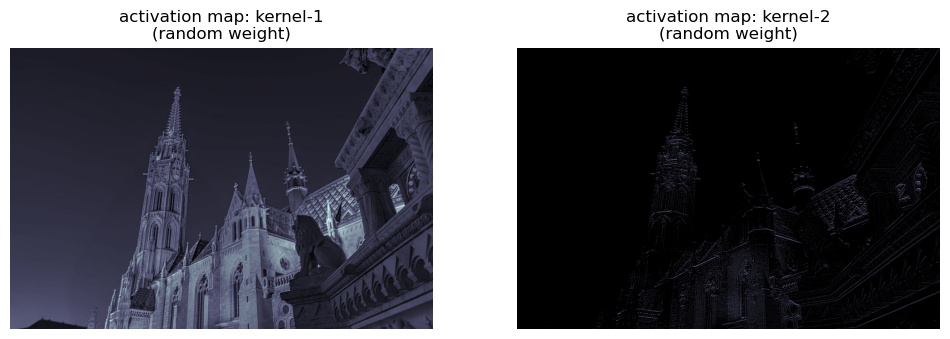

In [6]:
activation_maps = torch.relu(outputs)
titles = ["activation map: kernel-1\n(random weight)", 
          "activation map: kernel-2\n(random weight)"]
# Plot activation Maps
plot_maps(activation_maps.squeeze(), titles)

### Maxpooling Layer

[`nn.MaxPool2d`](https://pytorch.org/docs/stable/nn.html#maxpool2d) needs following arguments.

* `kernel_size`: kernel(filter) size, if integer type is given, it'll automatically set the same height and width. Also, can give tuple to give different size of height and width.
* `stride`: default as None, it will automatically equal to `kernel_size` 
* `return_indices`: return position of max pooled indices 

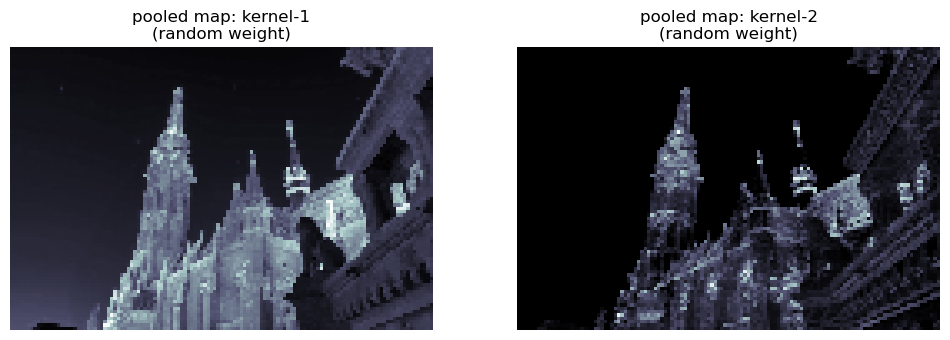

In [7]:
maxpool_layer = nn.MaxPool2d(kernel_size=10)
pooled_maps = maxpool_layer(activation_maps)
titles = ["pooled map: kernel-1\n(random weight)", 
          "pooled map: kernel-2\n(random weight)"]
# Plot Maxpooled Maps: 
plot_maps(pooled_maps.squeeze(), titles)

---

# Training CIFAR10 data

Cifar 10 is a classification problem with 10 classes, which has (32x32) size of RGB image.

<img src="http://drive.google.com/uc?export=view&id=1hUADKewEX64tB7vxVeYy2eKAJ4u4sVfb" width="480px" height="480px" >

## Loading Data & Preprocessing Pipeline

A pipeline refers to a sequence of data processing structure. In PyTorch, the image preprocessing pipeline usually uses `transforms` from the `torchvision` package.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [9]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2470, 0.2435, 0.2616)

img_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # random(with probability of 0.5) horizontal flip
    transforms.ToTensor(),  # change PIL Ojbect into Tensor (32, 32, 3) > (3, 32, 32)
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)  # normalizing with mean & std
])

topil = transforms.ToPILImage()
img_transformed = img_transformer(img)

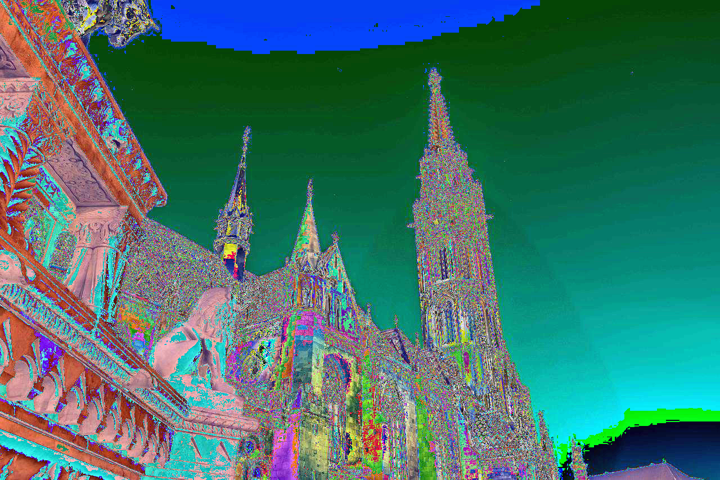

In [10]:
torch.manual_seed(774)
after_pipeline_img = topil(img_transformed)
after_pipeline_img.thumbnail((720, 1280))
after_pipeline_img

In [12]:
data_path = "./data/cifar10"

train_dataset = datasets.CIFAR10(
    root=data_path,
    train=True, 
    transform=img_transformer,
    download=True)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64, 
    shuffle=True)

test_dataset = datasets.CIFAR10(
    root=data_path,
    train=False, 
    transform=img_transformer,
    download=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64, 
    shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


---

## CNN Model

### Design Network

* Input Size = (B, 3, 32, 32)
* Output Size = (B, 10)
* Activation Function(`nn.ReLU`): ReLU
* Loss Function(`nn.CrossEntropyLoss`): Cross Entropy Loss
* Optimizer(`optim.Adam`): Adam
* Convolutional Layer: implement to `self.convs` with `nn.Sequential`
    > Conv1
    > 
    > 1. Conv(`nn.Conv2d`): input channel = 3, output channel = 8, kernel size = 3, stride = 1, padding = 1
    > 2. ReLU(`nn.ReLU`)
    > 3. MaxPool(`nn.MaxPool2d`): kernel size = 2
    > 
    > Conv2
    > 4. Conv(`nn.Conv2d`): input channel = 8, output channel = 16, kernel size = 3, stride = 1, padding = 0
    > 5. ReLU(`nn.ReLU`)
    > 6. MaxPool(`nn.MaxPool2d`): kernel size = 2
    > 
    > Conv3
    > 7. Conv(`nn.Conv2d`): input channel = 16, output channel = 32, kernel size = 2, stride = 1, padding = 0
    > 8. ReLU(`nn.ReLU`)
    > 9. MaxPool(`nn.MaxPool2d`): kernel size = 2
* Fully Connected Layer: implement to `self.fc` with `nn.Sequential`
    > 1. Linear(`nn.Linear`): Hidden Size = 100 (**need to calculate input neuron size**)
    > 2. ReLU(`nn.ReLU`)
    > 3. Linear(`nn.Linear`): Hidden Size = 100
    > 4. ReLU(`nn.ReLU`)
    > 5. Linear(`nn.Linear`): Hidden Size = 10

In [13]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # 층을 구성
        self.convs = nn.Sequential(
            # Conv1
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            # (B, 3, 32, 32) > (B, 8, 32, 32)
            nn.ReLU(),
            # (B, 8, 32, 32)
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (B, 8, 16, 16)
            
            # Conv2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1,padding=0),
            # (B, 8, 16, 16) > (B, 16, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (B, 16, 14, 14) > (B, 16, 7, 7)
            
            # Conv3
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1, padding=0),
            # (7+0-2)/1 + 1
            # (B, 16, 7, 7) > (B, 32, 6, 6)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (B, 32, 3, 3)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=32*3*3, out_features=100),  # tensor size ?
            nn.ReLU(), #(B, 100)
            nn.Linear(100, 100), #(B, 100) > (B, 100) weight(100, 100)
            nn.ReLU(),  
            nn.Linear(100, 10), 
        )
        
    def forward(self, x):
        # forward propagation
        # Conv Layers
        x = self.convs(x)
        # resize to (batch_size, 32*3*3)
        x = x.view(x.size(0), -1)
        # FC Layers
        x = self.fc(x)
        return x

### Define loss function and optimizer

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Network().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training Model

### Train function

In [16]:
def train(model, train_loader, loss_function, optimizer, print_step, device):
    # Training
    model.train()
    n_train = len(train_loader.dataset)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # 1) need to initialize for every trackable tensors
        optimizer.zero_grad()
        # 2) forward propagation
        output = model(data)
        # 3) calculate Loss
        loss = loss_function(output, target)
        # 4) back propagation
        loss.backward()
        # 5) update parameters
        optimizer.step()
        
        if batch_idx % print_step == 0:
            percentage = (batch_idx*train_loader.batch_size / n_train) * 100
            print(f" - [{percentage:.2f}%] train loss: {loss:.4f}")

### Validation function

In [20]:
def validation(model, test_loader, loss_function, device):
    # Validation
    model.eval()
    test_loss = 0
    correct = 0
    n_test = len(test_loader.dataset)

    with torch.no_grad():
        for data, target in test_loader:

            data, target = data.to(device), target.to(device)
            # 1) forward propagation
            output = model(data)
            # 2) calculate Loss
            test_loss += loss_function(output, target).item()
            # 3) predict the class
            pred = output.argmax(dim=1)
            # 4) calculate correct numbers
            correct += pred.eq(target).sum().item()
    test_accuracy = correct / n_test
    
    return test_loss, test_accuracy

### Start Training

In [21]:
n_step = 20
print_step = 300
best_accuracy = 0

for step in range(n_step):
    print(f"[Step] {step+1}/{n_step}\n [Training Step]")
    train(model, train_loader, loss_function, optimizer, print_step, device)
    test_loss, test_accuracy = validation(model, test_loader, loss_function, device)
    print(f" [Validation Step]")
    print(f" - test loss: {test_loss:.4f} test accuracy: {test_accuracy*100:.2f} %")
    # save best accuracy
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), "./states/best_model-cifar10.pt")

[Step] 1/20
 [Training Step]
 - [0.00%] train loss: 1.5108
 - [38.40%] train loss: 1.4252
 - [76.80%] train loss: 1.5101
 [Validation Step]
 - test loss: 207.8443 test accuracy: 51.79 %
[Step] 2/20
 [Training Step]
 - [0.00%] train loss: 1.5135
 - [38.40%] train loss: 1.3548
 - [76.80%] train loss: 1.1824
 [Validation Step]
 - test loss: 190.7126 test accuracy: 56.61 %
[Step] 3/20
 [Training Step]
 - [0.00%] train loss: 1.2329
 - [38.40%] train loss: 1.3938
 - [76.80%] train loss: 1.0719
 [Validation Step]
 - test loss: 178.5379 test accuracy: 59.50 %
[Step] 4/20
 [Training Step]
 - [0.00%] train loss: 1.0036
 - [38.40%] train loss: 1.2979
 - [76.80%] train loss: 1.1639
 [Validation Step]
 - test loss: 170.3752 test accuracy: 61.05 %
[Step] 5/20
 [Training Step]
 - [0.00%] train loss: 1.0948
 - [38.40%] train loss: 1.0784
 - [76.80%] train loss: 0.7323
 [Validation Step]
 - test loss: 167.2397 test accuracy: 62.45 %
[Step] 6/20
 [Training Step]
 - [0.00%] train loss: 0.9843
 - [38.40%]

## Imporve the performance

Insert Batch Normalization to imporve the performance.

In [22]:
class NetworkBN(nn.Module):
    def __init__(self):
        super().__init__()
        # Construct Layers
        self.convs = nn.Sequential(
            # Conv1
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            #(B, 3, 32, 32) > (B, 8, 32, 32)
            nn.ReLU(),
            # (B, 8, 32, 32)
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (B, 8, 16, 16)
            # Conv2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            # (B, 8, 16, 16) > (B, 16, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (B, 16, 14, 14) > (B, 16, 7, 7)
            # Conv3
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(32),
            # (7+0-2)/1 + 1
            # (B, 16, 7, 7) > (B, 32, 6, 6)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (B, 32, 3, 3)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=32*3*3, out_features=100),  # tensor size ?
            nn.ReLU(), #(B, 100)
            nn.Linear(100, 100), #(B, 100) > (B, 100) weight(100, 100)
            nn.ReLU(),  
            nn.Linear(100, 10), 
        )
        
    def forward(self, x):
        # forward propagation
        # Conv Layers
        x = self.convs(x)
        # resize to (batch_size, 32*3*3)
        x = x.view(x.size(0), -1)
        # FC Layers
        x = self.fc(x)
        return x

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NetworkBN().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_train = len(train_dataset)
n_test = len(test_dataset)
n_step = 20
print_step = 300
best_accuracy = 0

for step in range(n_step):
    print(f"[Step] {step+1}/{n_step}\n [Training Step]")
    train(model, train_loader, loss_function, optimizer, print_step, device)
    test_loss, test_accuracy = validation(model, test_loader, loss_function, device)
    print(f" [Validation Step]")
    print(f" - test loss: {test_loss:.4f} test accuracy: {test_accuracy*100:.2f} %")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), "./states/best_model-cifar10-bn.pt")

[Step] 1/20
 [Training Step]
 - [0.00%] train loss: 2.3318
 - [38.40%] train loss: 1.2437
 - [76.80%] train loss: 1.0682
 [Validation Step]
 - test loss: 192.4342 test accuracy: 56.35 %
[Step] 2/20
 [Training Step]
 - [0.00%] train loss: 1.0326
 - [38.40%] train loss: 1.1915
 - [76.80%] train loss: 1.1211
 [Validation Step]
 - test loss: 162.1835 test accuracy: 63.24 %
[Step] 3/20
 [Training Step]
 - [0.00%] train loss: 1.1206
 - [38.40%] train loss: 1.1585
 - [76.80%] train loss: 0.8974
 [Validation Step]
 - test loss: 154.2422 test accuracy: 65.04 %
[Step] 4/20
 [Training Step]
 - [0.00%] train loss: 0.8085
 - [38.40%] train loss: 1.0597
 - [76.80%] train loss: 0.8534
 [Validation Step]
 - test loss: 147.6555 test accuracy: 66.15 %
[Step] 5/20
 [Training Step]
 - [0.00%] train loss: 0.8969
 - [38.40%] train loss: 0.9988
 - [76.80%] train loss: 1.0755
 [Validation Step]
 - test loss: 141.3554 test accuracy: 68.23 %
[Step] 6/20
 [Training Step]
 - [0.00%] train loss: 1.0437
 - [38.40%]

---

# Data Augmentation: Augmentor

GitHub: https://github.com/mdbloice/Augmentor

```
$ pip install Augmentor
```

In [25]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [27]:
import Augmentor
path = Path("./imgs")

In [28]:
p = Augmentor.Pipeline(source_directory=path)
# rotate
p.rotate(probability=0.7, max_left_rotation=20, max_right_rotation=20)
# zoom
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)

Initialised with 1 image(s) found.
Output directory set to imgs\output.

In [29]:
p.sample(4)

Processing <PIL.Image.Image image mode=RGB size=634x423 at 0x24D749F7C40>: 100%|███| 4/4 [00:00<00:00, 63.49 Samples/s]


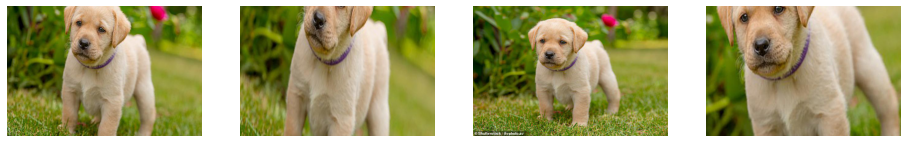

In [30]:
samples = list((path / "output").glob("*.jpg"))
fig, axes = plt.subplots(1, 4, figsize=(16, 16))
arrays = [np.array(Image.open(s)) for s in samples]
for i in range(4):
    axes[i].imshow(arrays[i])
    axes[i].axis("off")

# Transfer Learning

For custom dataset, `datasets.ImageFolder` offers useful tools

Let's say if we want to create a custom dog/cat classifier, we should create the data path like following, 

```
/datapath
├── /train
│    ├── /dog
│    │    ├── ...
│    │    ├── dog99.jpg
│    │    └── dog100.jpg
│    └── /cat
├── /valid
│    ├── /dog
│    └── /cat
└── /test
     ├── /dog
     └── /cat
```

here we're going to classify bees and ants, download the dataset `hymenoptera_data`

```
https://download.pytorch.org/tutorial/hymenoptera_data.zip
```

In [31]:
!tree "./data/hymenoptera_data"

폴더 PATH의 목록입니다.
볼륨 일련 번호가 00000054 E250:0AE5입니다.
C:\USERS\SIMON\DESKTOP\CODES\HANKYONG-UNIVERSITY\DATA\HYMENOPTERA_DATA
├─train
│  ├─ants
│  └─bees
└─val
    ├─ants
    └─bees


In [32]:
p = Augmentor.Pipeline()
p.rotate(probability=0.7, max_left_rotation=20, max_right_rotation=20)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.2)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Create augmentation pipeline
data_transforms = {
    "train": transforms.Compose([
        p.torch_transform(),  # offers to fit into torchvision pipeline
        transforms.RandomResizedCrop(224), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_path = Path("./data/hymenoptera_data")

img_datasets = {x: datasets.ImageFolder(
    root=str(data_path / x), 
    transform=data_transforms[x]) for x in ["train", "val"]}

data_loaders = {x: DataLoader(
    img_datasets[x], 
    batch_size=4,
    shuffle=True) for x in ["train", "val"]}

# check the data size
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val']}
# check the class names
class_names = img_datasets['train'].classes

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Data Size: {dataset_sizes}")
print(f"Class Name: {class_names}")

Data Size: {'train': 244, 'val': 153}
Class Name: ['ants', 'bees']


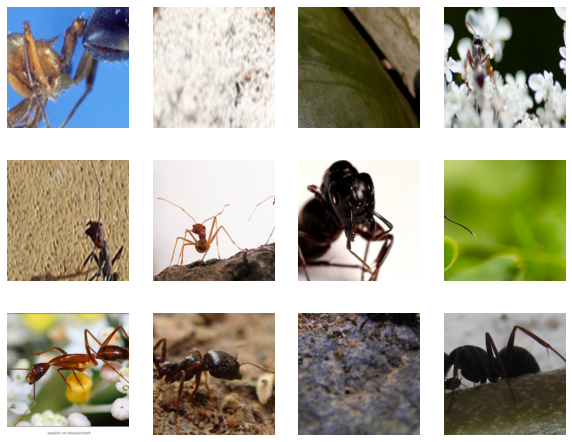

In [33]:
def img_show(img_tensors, mean, std):
    B, *_ = img_tensors.size()
    m = mean.unsqueeze(0).repeat(B, 1, 1, 1)
    s = std.unsqueeze(0).repeat(B, 1, 1, 1)
    imgs = img_tensors.mul_(s) + m
    fig, axes = plt.subplots(B//4, 4, figsize=(10, 8))
    for ax, img in zip(axes.flatten(), imgs):
        ax.imshow(img)
        ax.axis("off")

img_tensors = torch.stack(list(zip(*img_datasets["train"]))[0])[:12].permute(0, 2, 3, 1)
mean_tensor = torch.FloatTensor(mean)
std_tensor = torch.FloatTensor(std)

img_show(img_tensors, mean_tensor, std_tensor)

## CNN Models

### datasets.models packages

[`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) contains a lot of pretrained models, also if given `pretrained` argument as True, it will download pretrained weight that trained by ImageNet dataset. 

* pretrained model input image size = (224, 224)

In [34]:
from torchvision import models

model = models.vgg11(pretrained=True)

Download the vgg11 model

```
Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to C:\Users\simon/.cache\torch\checkpoints\vgg11-bbd30ac9.pth
100%|███████████████████████████████████████████████████████████████████████████████| 507M/507M [00:54<00:00, 9.82MB/s]
```

In [35]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## Fine Tuning

To fine tuning 2 classes, change the last classifier to new Linear layer.

In [36]:
def create_vgg11_model():
    model = models.vgg11(pretrained=True)
    in_features = model.classifier[0].in_features
    model.classifier = nn.Linear(in_features, 2)
    return model

In [37]:
model = create_vgg11_model()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = create_vgg11_model()
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# How to freeze model?
for name, params in model.named_parameters():
    if "features" in name:
        params.requires_grad_(False)
    else:
        pass

In [40]:
model.classifier.weight.requires_grad

True

In [41]:
def train(model, train_loader, loss_function, optimizer, print_step, device):
    # Training
    model.train()
    n_train = len(train_loader.dataset)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # 1) need to initialize for every trackable tensors
        optimizer.zero_grad()
        # 2) forward propagation
        output = model(data)
        # 3) calculate Loss
        loss = loss_function(output, target)
        # 4) back propagation
        loss.backward()
        # 5) update parameters
        optimizer.step()
        
        if batch_idx % print_step == 0:
            percentage = (batch_idx*train_loader.batch_size / n_train) * 100
            print(f" - [{percentage:.2f}%] train loss: {loss:.4f}")
            
def validation(model, test_loader, loss_function, device):
    # Validation
    model.eval()
    test_loss = 0
    correct = 0
    n_test = len(test_loader.dataset)

    with torch.no_grad():
        for data, target in test_loader:

            data, target = data.to(device), target.to(device)
            # 1) forward propagation
            output = model(data)
            # 2) calculate Loss
            test_loss += loss_function(output, target).item()
            # 3) predict the class
            pred = output.argmax(dim=1, keepdim=True)
            # 4) calculate correct numbers
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_accuracy = correct / n_test
    
    return test_loss, test_accuracy

In [42]:
n_train = dataset_sizes["train"]
n_test = dataset_sizes["val"]
n_step = 10
print_step = 15
best_accuracy = 0

for step in range(n_step):
    print(f"[Step] {step+1}/{n_step}\n [Training Step]")
    train(model, data_loaders["train"], loss_function, optimizer, print_step, device)
    test_loss, test_accuracy = validation(model, data_loaders["val"], loss_function, device)
    print(f" [Validation Step]")
    print(f" - test loss: {test_loss:.4f} test accuracy: {test_accuracy*100:.2f} %")
    
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), "./states/best_model-transferlearning.pt")

[Step] 1/10
 [Training Step]
 - [0.00%] train loss: 1.3592
 - [24.59%] train loss: 0.2337
 - [49.18%] train loss: 0.7643
 - [73.77%] train loss: 0.1753
 - [98.36%] train loss: 0.6327
 [Validation Step]
 - test loss: 11.7083 test accuracy: 92.16 %
[Step] 2/10
 [Training Step]
 - [0.00%] train loss: 0.1716
 - [24.59%] train loss: 0.5105
 - [49.18%] train loss: 0.2310
 - [73.77%] train loss: 0.1036
 - [98.36%] train loss: 0.1011
 [Validation Step]
 - test loss: 12.0783 test accuracy: 92.16 %
[Step] 3/10
 [Training Step]
 - [0.00%] train loss: 0.2756
 - [24.59%] train loss: 0.1779
 - [49.18%] train loss: 0.0679
 - [73.77%] train loss: 0.1374
 - [98.36%] train loss: 0.0396
 [Validation Step]
 - test loss: 12.1596 test accuracy: 91.50 %
[Step] 4/10
 [Training Step]
 - [0.00%] train loss: 0.4997
 - [24.59%] train loss: 0.0371
 - [49.18%] train loss: 0.0306
 - [73.77%] train loss: 0.0934
 - [98.36%] train loss: 0.3786
 [Validation Step]
 - test loss: 10.6237 test accuracy: 90.85 %
[Step] 5/10


## Test

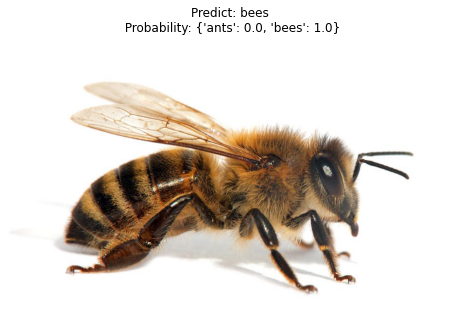

In [43]:
test_img = Image.open("bee.jpg")
# test_img = Image.open("../data/hymenoptera_data/train/ants/0013035.jpg")

test_input = data_transforms["val"](test_img).unsqueeze(0)
model = create_vgg11_model()
model.load_state_dict(torch.load("./states/best_model-transferlearning.pt", 
                                 map_location="cpu"))
output = model(test_input).detach()
predict = output.argmax(1).item()
prob_dict = {c: p for c, p in zip(class_names, 
                          output.softmax(1).squeeze().numpy().round(4))}


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(np.array(test_img))
ax.set_title(f"Predict: {class_names[predict]}\n Probability: {prob_dict}")
ax.axis("off")
plt.show()